Menghubungkan dengan Drive



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score,confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay,
)

Memanggil folder dataset

In [3]:
# Read the CSV file with a comma delimiter
df = pd.read_csv('/content/drive/MyDrive/praktikum_ml/praktikum04/data/stunting_wasting_dataset.csv')

# Cetak header data (5 baris pertama) dari file
display(df.head())

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


Membaca data file CSV

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [5]:
#cek missing value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


Cek nilai unik

In [6]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [7]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

Mapping kolom kategori ke bentuk numerik

In [8]:
#1. Mapping kolom stunting -> biner
map_stunt = {'Stunded': 1, 'Severely Stunted': 1, 'Normal':0, 'Tall':0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

#2. Mapping kolom jenis kelamin -> biner
#Laki-laki = 1, perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype('int')

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    78021
1     5819
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


Analisis Korelasi Antar Variabel Numerik

In [9]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,-0.026569,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.242181,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,-0.021854,0.045797
Stunting_bin,-0.026569,-0.242181,-0.021854,1.000000,0.004442
JK_bin,0.004046,0.073505,0.045797,0.004442,1.000000


Visualisasi Heatmap Korelasi

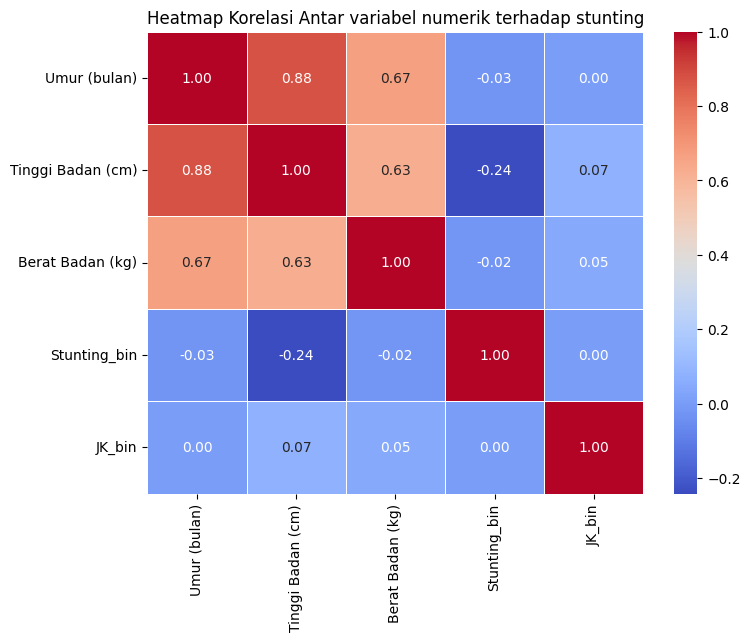

In [10]:
#Visualisasi Heatmap Korelasi
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Antar variabel numerik terhadap stunting', fontsize=12)
plt.show()

Pembagian Dataset (Training dan Testing)

In [11]:
# Fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# Gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape", X.shape)
print("y shape", y.shape)


X shape (83840, 4)
y shape (83840,)


Membagi Dataset menjadi Training dan Testing Set

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (67072, 4)
Data uji: (16768, 4)


In [13]:
#Scale hanya fitur numerik, gender langsung passtrhought
preprocessing = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('prep', preprocessing),
    ('algo', model)
])

#Latih Model
clf.fit(X_train, y_train)
print("Model Logistic Regression berhasil dilatih.")

Model Logistic Regression berhasil dilatih.


In [14]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi   : 0.9427
Precision : 0.5481
Recall    : 0.9991
F1-Score  : 0.7079
ROC-AUC   : 0.9836


Prediksi Model dan Evaluasi Model


In [15]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score  : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC   : {roc_auc_score(y_test, y_prob):.4f}")

Akurasi   : 0.9427
Precision : 0.5481
Recall    : 0.9991
F1-Score  : 0.7079
ROC-AUC   : 0.9836


Visualisasi Hasil Evaluasi


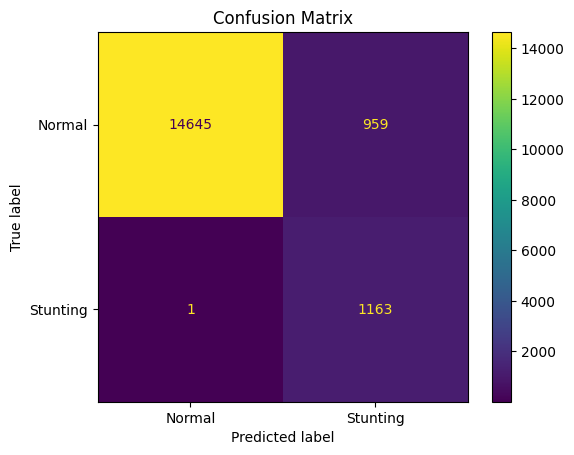

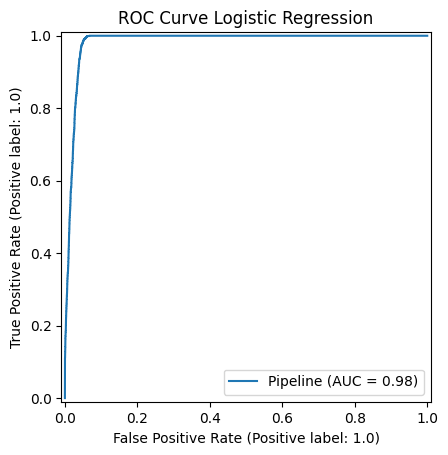

In [16]:
# Confusion Matrix
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=['Normal', 'Stunting']
).plot(values_format='d')

plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()


Classification Report

In [17]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_pred,
    target_names=['Tidak Stunting (0)', 'Stunting (1)']
))


                    precision    recall  f1-score   support

Tidak Stunting (0)       1.00      0.94      0.97     15604
      Stunting (1)       0.55      1.00      0.71      1164

          accuracy                           0.94     16768
         macro avg       0.77      0.97      0.84     16768
      weighted avg       0.97      0.94      0.95     16768



In [21]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil
print("Skor tiap fold      :", scores)
print("Rata-rata akurasi   :", np.mean(scores))
print("Standar deviasi     :", np.std(scores))


Skor tiap fold      : [0.94250954 0.93821565 0.94221135 0.93863311 0.93684399]
Rata-rata akurasi   : 0.9396827290076336
Standar deviasi     : 0.00226703731795664


In [24]:
# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['algo'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur': feat_names,
    'Koefisien (log-odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)

display(coef_df)


,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),11.410722,9.028462e+04
3,JK_bin,2.462657,1.173596e+01
2,Berat Badan (kg),0.892433,2.441061e+00
1,Tinggi Badan (cm),-14.377466,5.700934e-07


 Prediksi Data Baru (Contoh Kasus)

In [25]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]  # 1 = Laki-laki, 0 = Perempuan
})

# Prediksi
pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

# Gabungkan hasil
hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak, 1=Ya)'] = pred

# Tampilkan hasil
display(hasil)


,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak, 1=Ya)"
0,24,79.0,9.2,1,0.999289,1.0
1,10,72.5,7.8,0,0.000057,0.0


Praktikum Mandiri

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Baca dataset calon pembeli mobil

In [27]:
# Read the CSV file with a comma delimiter
df = pd.read_csv('/content/drive/MyDrive/praktikum_ml/praktikum04/data/calonpembelimobil.csv')

# Cetak header data (5 baris pertama) dari file
display()

Cek informasi dataset

In [30]:
print("=== Informasi Dataset ===")
print(df.info())
print("\n=== Statistik Deskriptif ===")
print(df.describe())
print("\n=== 5 Baris Pertama ===")
display(df.head())

=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ID              1000 non-null   int64
 1   Usia            1000 non-null   int64
 2   Status          1000 non-null   int64
 3   Kelamin         1000 non-null   int64
 4   Memiliki_Mobil  1000 non-null   int64
 5   Penghasilan     1000 non-null   int64
 6   Beli_Mobil      1000 non-null   int64
dtypes: int64(7)
memory usage: 54.8 KB
None

=== Statistik Deskriptif ===
                ID         Usia       Status      Kelamin  Memiliki_Mobil  \
count  1000.000000  1000.000000  1000.000000  1000.000000      1000.00000   
mean    500.500000    43.532000     1.469000     0.481000         0.95200   
std     288.819436    12.672078     1.073402     0.499889         0.80146   
min       1.000000    24.000000     0.000000     0.000000         0.00000   
25%     250.750000    3

,ID,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Beli_Mobil
0,1,32,1,0,0,240,1
1,2,49,2,1,1,100,0
2,3,52,1,0,2,250,1
3,4,26,2,1,1,130,0
4,5,45,3,0,2,237,1


Mengecek Nilai Kosong

In [31]:
print("\n=== Cek Nilai Kosong ===")
print(df.isnull().sum())


=== Cek Nilai Kosong ===
ID                0
Usia              0
Status            0
Kelamin           0
Memiliki_Mobil    0
Penghasilan       0
Beli_Mobil        0
dtype: int64


Pisahkan Fitur (X) dan Target (y)

In [33]:
X = df.drop(['ID', 'Beli_Mobil'], axis=1)  # hapus kolom ID & target
y = df['Beli_Mobil']

Bagi Dataset Menjadi Data Latih & Uji

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Standarisasi Fitur

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Buat Model Logistic Regression

In [36]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

Evaluasi Model

In [37]:
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

print("\n=== Evaluasi Model ===")
print(f"Akurasi   : {accuracy_score(y_test, y_pred):.4f}")
print("\n=== Laporan Klasifikasi ===")
print(classification_report(y_test, y_pred))


=== Evaluasi Model ===
Akurasi   : 0.9250

=== Laporan Klasifikasi ===
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        64
           1       0.94      0.96      0.95       136

    accuracy                           0.93       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.93      0.92       200



Confusion Matrix

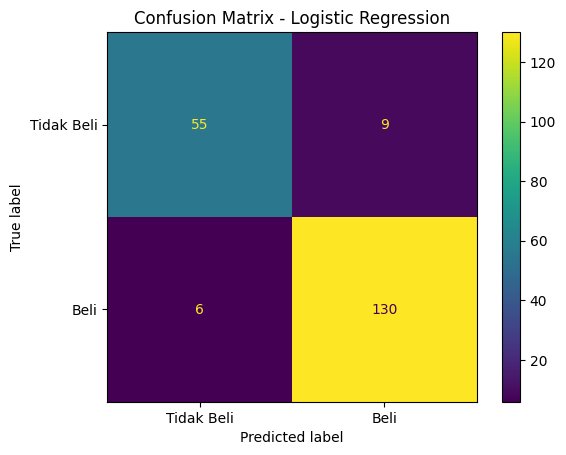

In [38]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Tidak Beli', 'Beli']).plot(values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Uji Dengan Dataset Baru

In [39]:
data_baru = pd.DataFrame({
    'Usia': [30, 50],
    'Status': [1, 2],
    'Kelamin': [0, 1],
    'Memiliki_Mobil': [0, 1],
    'Penghasilan': [200, 350]
})

In [41]:
# Standarisasi data baru
data_baru_scaled = scaler.transform(data_baru)

# Prediksi
pred = clf.predict(data_baru_scaled)
prob = clf.predict_proba(data_baru_scaled)[:, 1]

hasil = data_baru.copy()
hasil['Prob_Beli'] = prob
hasil['Prediksi (0=Tidak,1=Beli)'] = pred

print("\n=== Hasil Prediksi Dataset Baru ===")
display(hasil)


=== Hasil Prediksi Dataset Baru ===


,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Prob_Beli,"Prediksi (0=Tidak,1=Beli)"
0,30,1,0,0,200,0.400938,0
1,50,2,1,1,350,0.997594,1
